In [3]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
import itertools
import random

max_min_scalar = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

# 读入样本信息
all_colinfo = pd.read_csv("GSE143155_group.csv",index_col = 0)

# 加载系数
coefs = pd.read_csv("./set_coefs.csv",index_col = 0)
resx = coefs.iloc[:,0].values
# 读入数据
geneExpr = pd.read_csv("GSE143155_expr.csv",index_col = 0)
geneExpr = geneExpr.T
geneExpr = geneExpr*1.0 # DataFrame

all_colinfo.index = geneExpr.index   # 这行很重要，要不然总报错
geneExpr = geneExpr.apply(max_min_scalar,axis = 0) 
geneExpr = geneExpr.fillna(0)

moduleGene = pd.read_csv("module_genes_input.csv",index_col = 0)
data_gene_all = set(geneExpr.columns)

OrGene = moduleGene.iloc[0,:]
OrGene_ok = []
for i in range(len(OrGene)):
    if OrGene[i] in data_gene_all:
        OrGene_ok.append(OrGene[i])            
Num_Or = len(OrGene_ok)
RsGene = moduleGene.iloc[1,:]
RsGene_ok = []
for i in range(len(RsGene)):
    if RsGene[i] in data_gene_all:
        RsGene_ok.append(RsGene[i])
            
Num_Rs = len(RsGene_ok)
OsGene = moduleGene.iloc[2,:]
OsGene_ok = []
for i in range(len(OsGene)):
    if OsGene[i] in data_gene_all:
        OsGene_ok.append(OsGene[i])

            
Num_Os = len(OsGene_ok)

Expr_Or = geneExpr[OrGene_ok]
Expr_Rs = geneExpr[RsGene_ok]
Expr_Os = geneExpr[OsGene_ok]

# 计算交互项
poly = PolynomialFeatures(interaction_only=True,include_bias = False) #定义了一个转化器

temp = pd.DataFrame(poly.fit_transform(Expr_Or))
temp.index = Expr_Or.index
original_names = list(Expr_Or.columns)
inter_names = ['_'.join(x) for x in list(itertools.combinations(original_names,2))]
all_names = original_names+inter_names
temp.columns = all_names
Expr_Or0 = temp

temp = pd.DataFrame(poly.fit_transform(Expr_Rs))
temp.index = Expr_Rs.index
original_names = list(Expr_Rs.columns)
inter_names = ['_'.join(x) for x in list(itertools.combinations(original_names,2))]
all_names = original_names+inter_names
temp.columns = all_names
Expr_Rs0 = temp

temp = pd.DataFrame(poly.fit_transform(Expr_Os))
temp.index = Expr_Os.index
original_names = list(Expr_Os.columns)
inter_names = ['_'.join(x) for x in list(itertools.combinations(original_names,2))]
all_names = original_names+inter_names
temp.columns = all_names
Expr_Os0 = temp

Expr_Or0 = Expr_Or0.apply(max_min_scalar,axis = 0)
Expr_Rs0 = Expr_Rs0.apply(max_min_scalar,axis = 0)
Expr_Os0 = Expr_Os0.apply(max_min_scalar,axis = 0)
len_Or = Expr_Or0.shape[1]
len_Rs = Expr_Rs0.shape[1]
len_Os = Expr_Os0.shape[1]
# 到目前位置 Expr_Or0，Expr_Rs0，Expr_Os0为三个输入矩阵，Num_Or，Num_Rs，Num_Os为三个基因个数，行数为BATCH_SIZE



values_Os = np.dot(Expr_Os0, resx[2 + Expr_Or0.shape[1] + Expr_Rs0.shape[1]:2 + Expr_Or0.shape[1] + Expr_Rs0.shape[1] +
                                                                       Expr_Os0.shape[1]])
output_results = values_Os.reshape(Expr_Or0.shape[0], 1)
output_results = pd.DataFrame(output_results)
output_results.columns = ["OxiStress"]
output_results.index = all_colinfo.index
output_results = pd.concat([output_results, all_colinfo], axis=1)

output_results.to_csv("./results.csv")

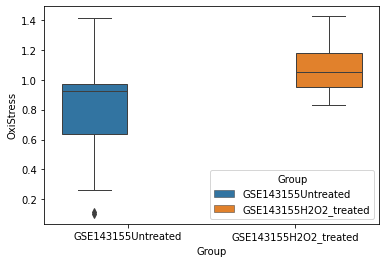

In [4]:
import seaborn as sns
ax = sns.boxplot(x = "Group",y = "OxiStress",hue = "Group", data=output_results, linewidth=1)